In [56]:
# this cut will do a log transform - and try different ARIMA (p,d,q)

1 - Data Wrangling, Visualise the TS
2 - Stationarise the TS
3 - Plot ACF/PACF and find optimal parameters
4 - Build Arima model
5 - Make Forecast

# 1. Visualise the TS

First step is to visualize the data to understand what type of model to use later on.
Is there an overall trend in your data that I should be aware of? 
Does the data show any seasonal trends? If there isn’t a seasonal trend in the data, I can just use a regular ARIMA model instead. 

In [6]:
# set up the environment for the data exploration
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
#from statsmodels.tsa.stattools import statespace
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
# read in the csv file as a df, declaring null values, and initial look at the type of data and data types 
data1 = pd.read_csv('aud_fx_thb_jpy_usd.csv', na_values=[' '])
# drop the null values from df
data1= pd.DataFrame(data1).dropna()
# do a df.describe to have a feel of the key stats of each currency pair 
#- counts, high, low, increase, decrease, anomalies
np.round(data1.describe(), 2)

,AUDTHB,AUDJPY,AUDUSD
count,2790.00,2790.00,2790.00
mean,28.86,87.10,0.88
std,2.33,9.35,0.12
min,20.98,56.39,0.60
25%,27.47,80.98,0.77
50%,29.14,86.94,0.89
75%,30.45,94.35,0.97
max,33.38,107.57,1.10


*Observations:
1. the sample size of each currency pair are even: n= 2790
2. the scale of USD exchange rates are quite wide between the currency pairs, eg. mean value from AUD0.88 to JPY100
3. it is hard to compare the spread of each currency pair's exchange rate, looking at the 25% and 75% percentile numbers, so it may be better to visualise this with box plots.

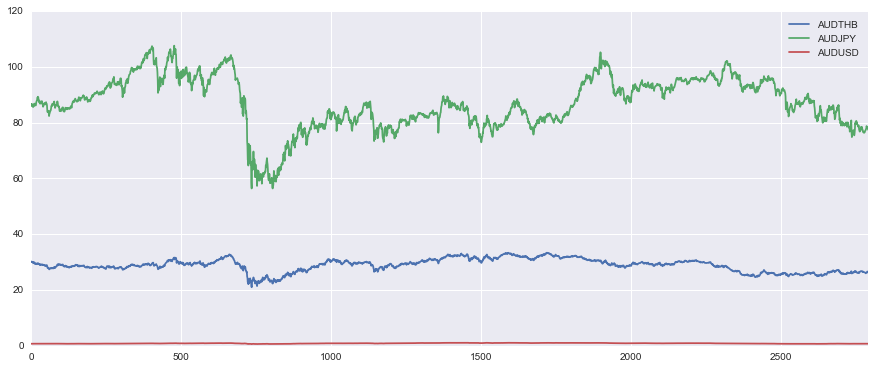

In [8]:
# try a numpy plot to compare the 3 time series pairs
data1.plot()

* Observations:

1. looks okay, but the scale problem is obscuring the trends of the low range currency pairs, ie. US_AUD and US_THB
2. I can improve the chart by 'normalising' the currency pairs first

In [9]:
# normalise the currency pairs by multiplying US_AUD rate by the approx mean ratio of US_THB/US_AUD (~35)
# and dividing the US/JPY rates by approx mean ratio of US_JPY/US_THB (~3)data_adj = data
data_adj = data1
data_adj['AUDUSD_ADJ'] = data_adj['AUDUSD'] * 35
data_adj['AUDJPY_ADJ'] = data_adj['AUDJPY'] / 3
data_adj = data_adj.drop('AUDUSD', 1)
data_adj = data_adj.drop('AUDJPY', 1)
print (data_adj.head())

       Date  AUDTHB  AUDUSD_ADJ  AUDJPY_ADJ
0  2-Jan-06  30.080     25.6585   28.823333
1  3-Jan-06  30.160     25.8930   28.653333
2  4-Jan-06  30.195     26.1730   28.906667
3  5-Jan-06  30.050     26.1625   28.876667
4  6-Jan-06  29.990     26.3935   28.760000


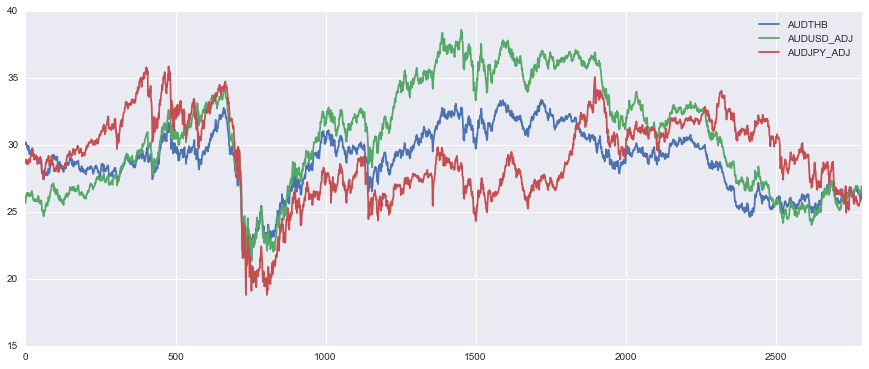

In [10]:
# try the numpy plot again to compare the adjusted time series pairs
data_adj.plot()

* Observations:

1. looks better this time, if the exchange rate scale is ignored, there is better relative granularity for the comparisons
2. the currency pairs appears to trend the same way, but AUDJPY is trending weaker than AUDJPYduring the mid years; we will look at the correlation of the currency pairs at a later step.
3. the next step is to decompose and visualise the ts into trend and seasonal components

In [11]:
# for a start, there is a need to change 'Date' from data type 'object' to TS object
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%b-%y')
import statsmodels.api as sm

In [12]:
# followed by a ts parse of the same original CVS data
data2 = pd.read_csv('aud_fx_thb_jpy_usd.csv', na_values=[' '], parse_dates=[0], index_col=[0], date_parser=dateparse)
# drop the null values
data2= pd.DataFrame(data2).dropna()

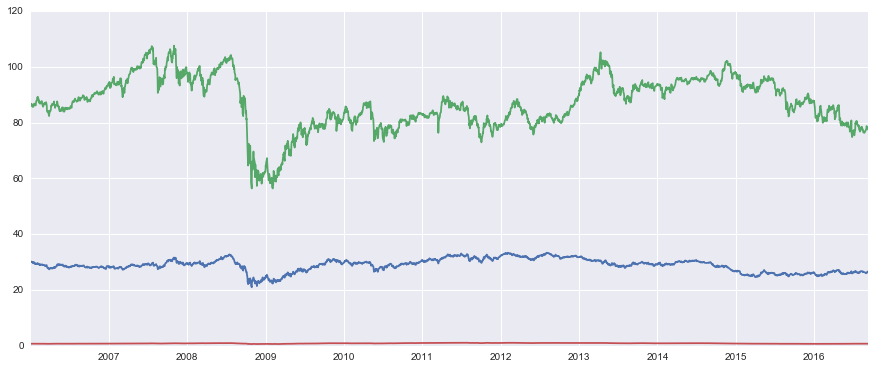

In [13]:
# do a ts plot
plt.plot(data2)

* To visualise trend and seasonal component before I staionalise the ts, 
* I can use the seasonal_decompose function in statsmodel.

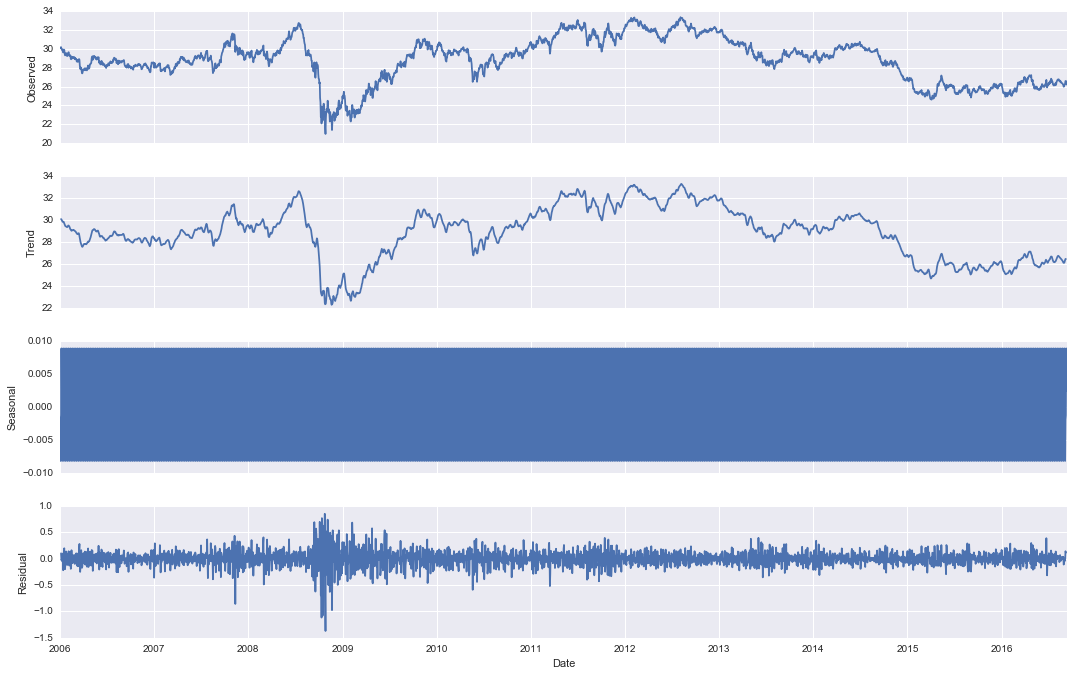

In [14]:
# for AUDTHB
decomp = sm.tsa.seasonal_decompose(data2.AUDTHB)
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,10)

* Observations:

1. the residual values essentially take out the trend and seasonality of the data, making the values independent of time. 
2. This is important because when running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. 
3. Since a lot of nice statistical tests can be done data with independent random variables (central limit theorem), it is useful to make the ts data stationary, so regression techniques can be applied to the time dependent variable.

In [15]:
# investigate why seasonal component plotted different
#decomp = sm.tsa.seasonal_decompose(data2.AUDTHB)
#trend = decomp.trend
seasonal = decomp.seasonal
#residual = decomp.resid
np.round(seasonal.describe(),5)

count    2790.00000
mean        0.00000
std         0.00561
min        -0.00818
25%        -0.00191
50%        -0.00125
75%         0.00247
max         0.00888
Name: AUDTHB, dtype: float64

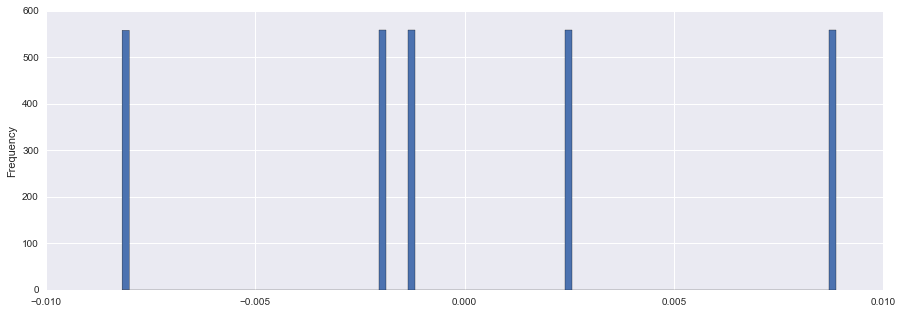

In [16]:
seasonal.plot(kind='hist',figsize=(15,5),bins=100)

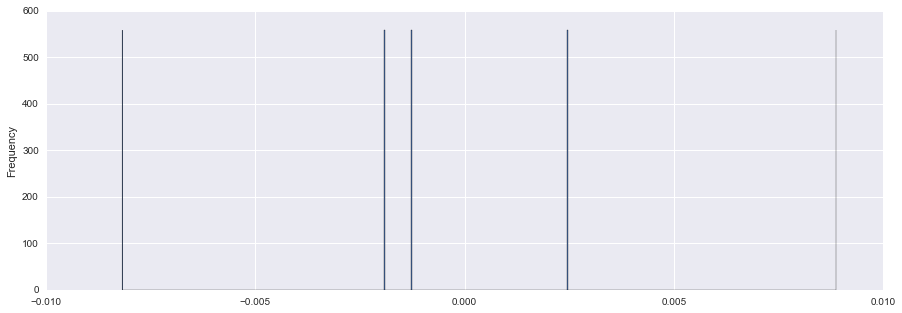

In [17]:
seasonal.plot(kind='hist',figsize=(15,5),bins=1000)

In [18]:
# looks like values are very discrete, around a fw values
np.histogram(seasonal)

(array([558,   0,   0, 558, 558,   0, 558,   0,   0, 558], dtype=int64),
 array([-0.00818346, -0.00647681, -0.00477017, -0.00306353, -0.00135688,
         0.00034976,  0.0020564 ,  0.00376304,  0.00546969,  0.00717633,
         0.00888297]))

In [70]:
# Conclusion here is that FX time series DO NOT have seasonal component (fair enough!)

# 2. Stationarise the TS

* Stationarity of a time series can be initially ascertained by visualizing the data to identify a changing mean or variation in the data. 
* However, a for more accurate assessment, the Dickey-Fuller test can be applied. 
* The ‘Test Statistic’ has to be less than the ‘Critical Value’ for the time series to be considered already stationary. 

In [19]:
# this function calculates the rolling stats and Dicker-Fuller stats to test staionarity
#from statsmodels.tsa.stattools import adfuller
from pandas import Series
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    #fig = plt.figure(figsize=(12, 8)) 
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
 
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


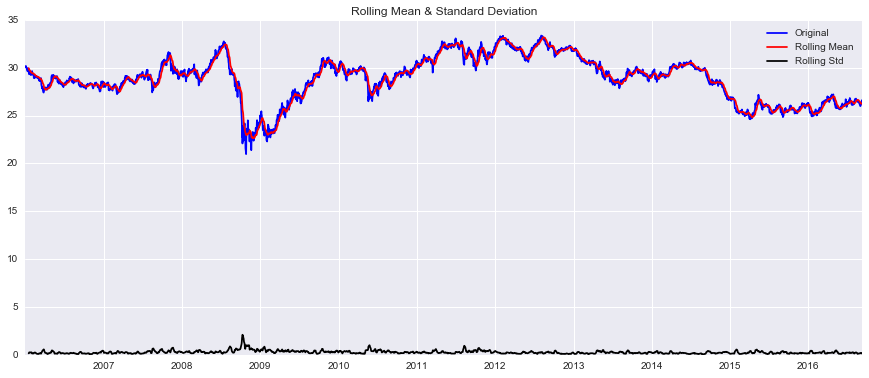

Results of Dickey-Fuller Test:
Test Statistic                   -2.152211
p-value                           0.224045
#Lags Used                        6.000000
Number of Observations Used    2783.000000
Critical Value (5%)              -2.862579
Critical Value (10%)             -2.567323
Critical Value (1%)              -3.432702
dtype: float64


In [20]:
# executes the test with the hypothesis:
# HO - the time series is non-staionary
# H1 - the time series is stationary
test_stationarity(data2.AUDTHB)

* Observations:

1. Dickey-Fuller is one of the statistical tests for checking stationarity. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.
2. the results of the test above shows a Test Stats of -2.15 This is greater than the 1%,5% and 10% critical value. 
3. hence, going by a 1% critical value, we accept HO: the TS is non-stationary, ie. further work can be done to transform the data to make it stationary for modelling.

* Transform data - step 1: take a first difference of the data. This should help to eliminate the overall trend from the data.

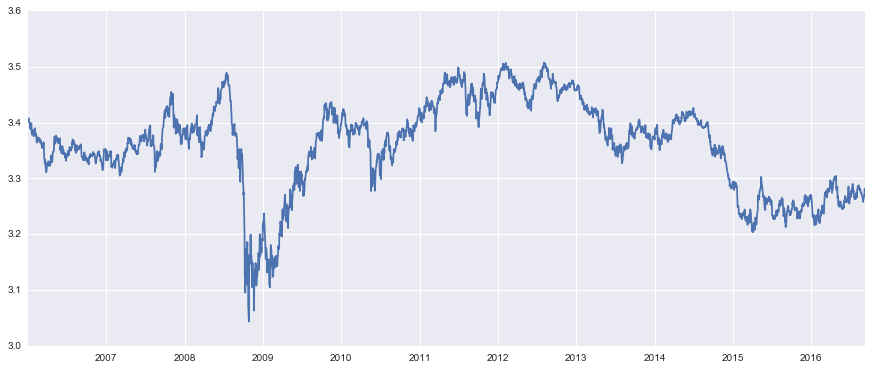

In [21]:
#transform to log 
data3 = np.log (data2.AUDTHB)
plt.plot(data3)

* Transform data - step 2: take a seasonal difference to remove the seasonality of the data and see how that impacts the stationarity of the data.

C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  from ipykernel import kernelapp as app


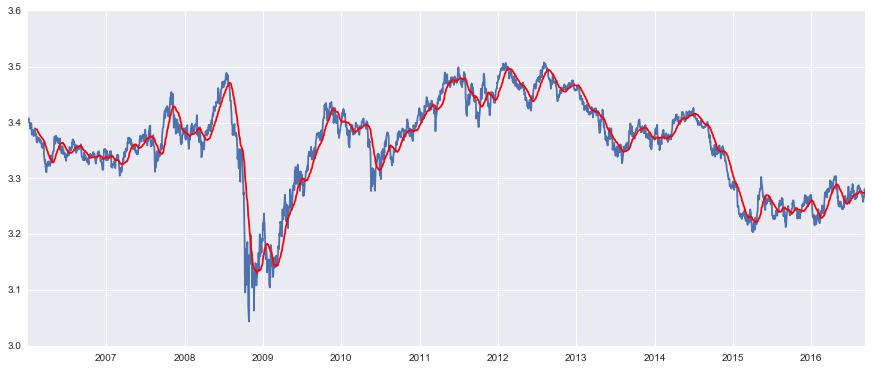

In [22]:
# use moving average to remove trend - take k = 30days
data3_mov_avg = pd.rolling_mean(data3,30)
plt.plot(data3)
plt.plot(data3_mov_avg, color='red')

In [23]:
# subtract moving avg from original series - lose first 29 data points
data3_mov_avg_diff = data3 - data3_mov_avg
data3_mov_avg_diff.head(35)

Date
2006-01-02         NaN
2006-01-03         NaN
2006-01-04         NaN
2006-01-05         NaN
2006-01-06         NaN
2006-01-09         NaN
2006-01-10         NaN
2006-01-11         NaN
2006-01-12         NaN
2006-01-13         NaN
2006-01-16         NaN
2006-01-17         NaN
2006-01-18         NaN
2006-01-19         NaN
2006-01-20         NaN
2006-01-23         NaN
2006-01-24         NaN
2006-01-25         NaN
2006-01-26         NaN
2006-01-27         NaN
2006-01-30         NaN
2006-01-31         NaN
2006-02-01         NaN
2006-02-02         NaN
2006-02-03         NaN
2006-02-06         NaN
2006-02-07         NaN
2006-02-08         NaN
2006-02-09         NaN
2006-02-10   -0.022858
2006-02-13   -0.022745
2006-02-14   -0.012017
2006-02-15   -0.016368
2006-02-16   -0.013049
2006-02-17   -0.015029
Name: AUDTHB, dtype: float64

C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


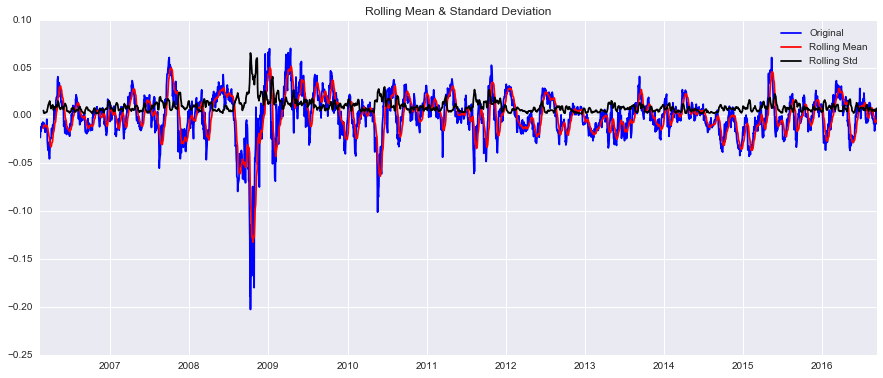

Results of Dickey-Fuller Test:
Test Statistic                -9.207992e+00
p-value                        1.921587e-15
#Lags Used                     1.300000e+01
Number of Observations Used    2.747000e+03
Critical Value (5%)           -2.862593e+00
Critical Value (10%)          -2.567330e+00
Critical Value (1%)           -3.432733e+00
dtype: float64


In [24]:
# drop Nan and check stationarity plots
data3_mov_avg_diff.dropna(inplace=True)
test_stationarity(data3_mov_avg_diff)

C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,halflife=15,adjust=True,min_periods=0).mean()
  from ipykernel import kernelapp as app


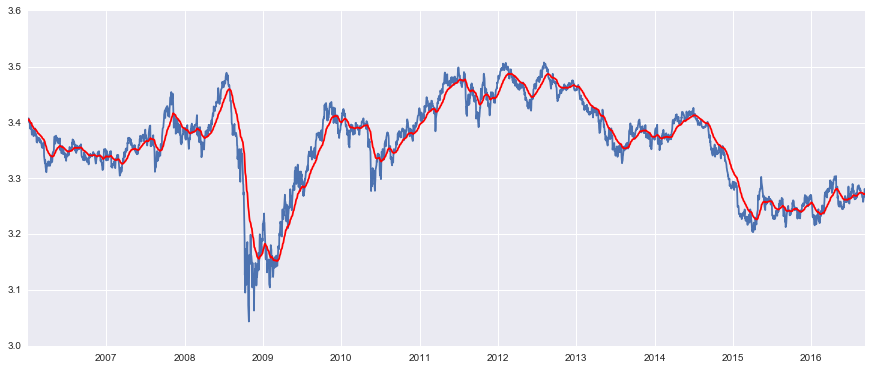

In [25]:
# transform with exponentially weighted moving avg, half-life of 15 days
exp_mov_avg = pd.ewma(data3,halflife=15)
plt.plot(data3)
plt.plot(exp_mov_avg, color='red')

C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


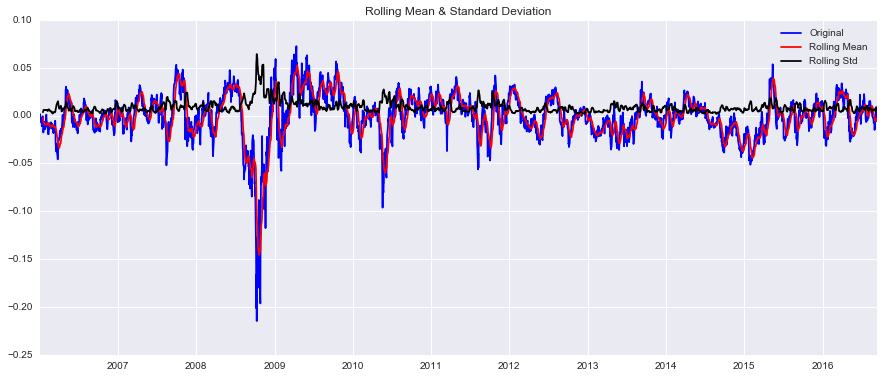

Results of Dickey-Fuller Test:
Test Statistic                -7.024158e+00
p-value                        6.428633e-10
#Lags Used                     1.300000e+01
Number of Observations Used    2.776000e+03
Critical Value (5%)           -2.862582e+00
Critical Value (10%)          -2.567325e+00
Critical Value (1%)           -3.432708e+00
dtype: float64


In [26]:
# remove weighted avg and check stationarity
exp_mov_avg_diff = data3 - exp_mov_avg
test_stationarity(exp_mov_avg_diff)

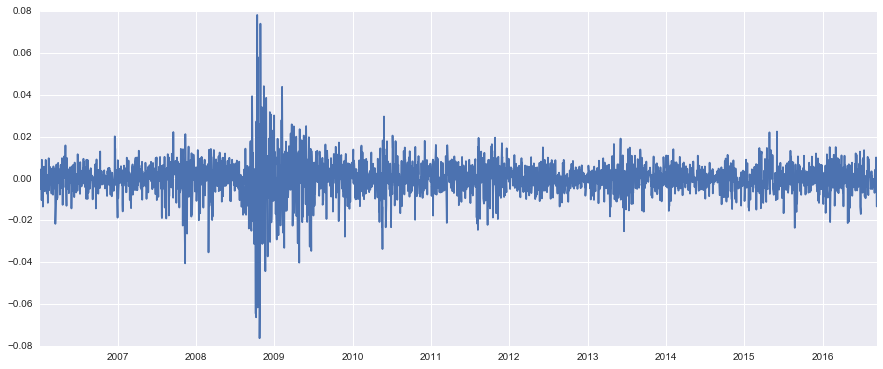

In [27]:
# now try first -order differencing
data3_diff = data3 - data3.shift()
plt.plot(data3_diff)

C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


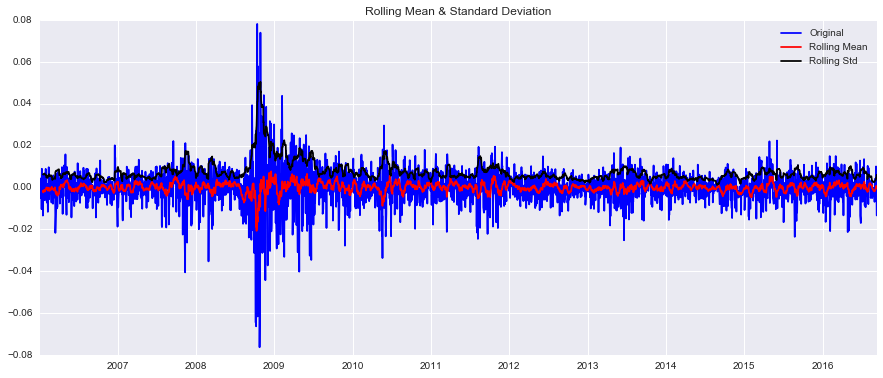

Results of Dickey-Fuller Test:
Test Statistic                -1.445547e+01
p-value                        6.985241e-27
#Lags Used                     1.200000e+01
Number of Observations Used    2.776000e+03
Critical Value (5%)           -2.862582e+00
Critical Value (10%)          -2.567325e+00
Critical Value (1%)           -3.432708e+00
dtype: float64


In [28]:
# appears to have reduced trend considerably. verify with stationary test
data3_diff.dropna(inplace=True)
test_stationarity(data3_diff)

Note the log first order difference transformation method makes it easy to revert back to original values from a model
This (provided the Dicker Fuller test shows staionarity) method will be used later to produce the ARIMA model

In [29]:
# using decompose method here
#from sm.statsmodels.tsa.seasonal import seasonal_decompose
#from sm.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.seasonal import seasonal_decompose
#decomposition = seasonal_decompose(data3)
#decomp = sm.tsa.seasonal_decompose(data2.AUDTHB)
decomposition = sm.tsa.seasonal_decompose(data3)
decomposition


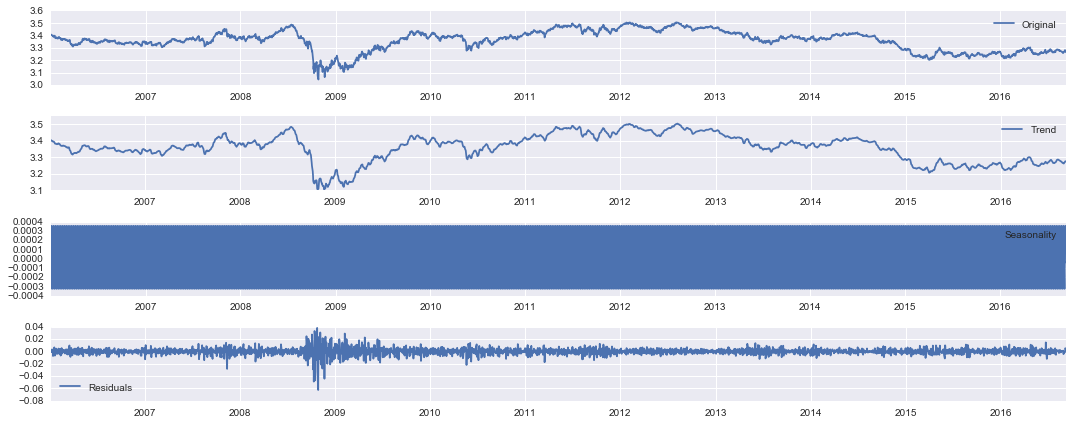

In [30]:
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(411)
plt.plot(data3,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\rob7l\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


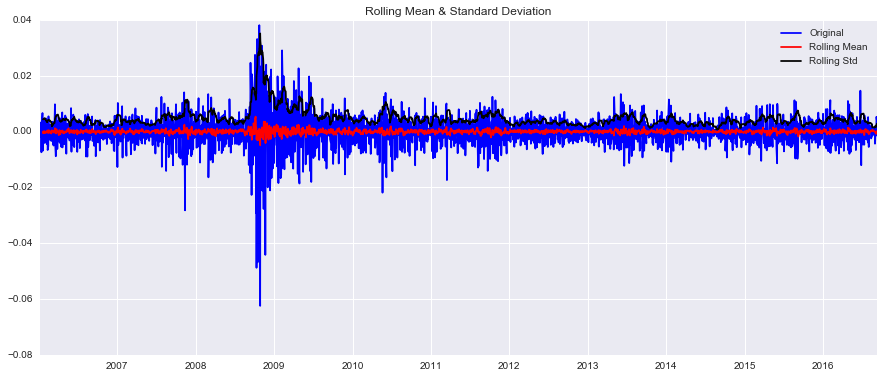

Results of Dickey-Fuller Test:
Test Statistic                -1.859477e+01
p-value                        2.071862e-30
#Lags Used                     2.700000e+01
Number of Observations Used    2.758000e+03
Critical Value (5%)           -2.862589e+00
Critical Value (10%)          -2.567328e+00
Critical Value (1%)           -3.432723e+00
dtype: float64


In [31]:
# trend and seasonality is now separated out; I can now model residuals
data3_decompose=residual
data3_decompose.dropna(inplace=True)
test_stationarity(data3_decompose)

The test statistic is significantly lower than 1% critical value. Hence this TS is very close to stationary

# 3 - Plot ACF/PACF and find optimal parameters

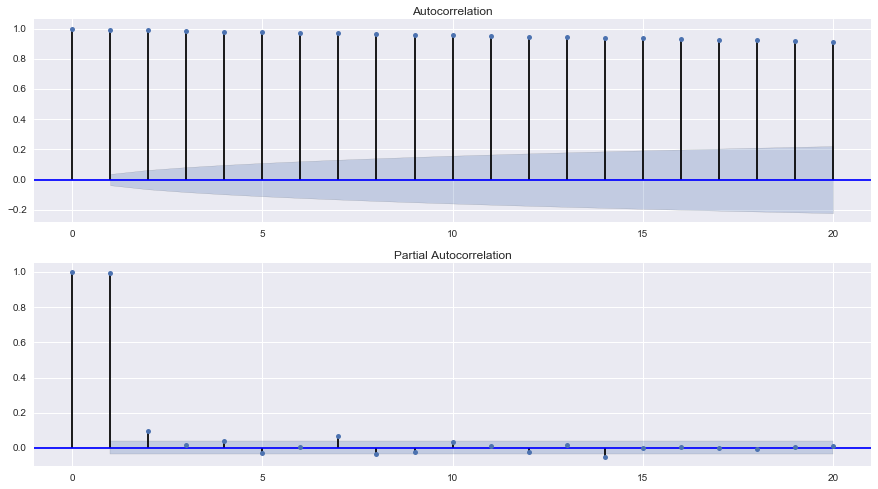

In [32]:
# ACF and PACF values will be derived from step1 first difference data
# correlation is computed at each lag step that is NOT already explained by previous, lower-order lag steps.
# cos the diff is calculated per day lag, iloc here is 1, 
# and it didn't make any difference (tested) if I changed iloc to > 1; the plots shows this as well
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data3.iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data3.iloc[1:], lags=20, ax=ax2)

In [33]:
#another way to work out ACF and PACF plots using log first order difference data calculated arlier
#ACF and PACF plots:
#from statsmodels.tsa.stattools import acf, pacf
lag_acf=acf(data3_diff,nlags=20)
lag_pacf=pacf(data3_diff,nlags=20,method='ols')

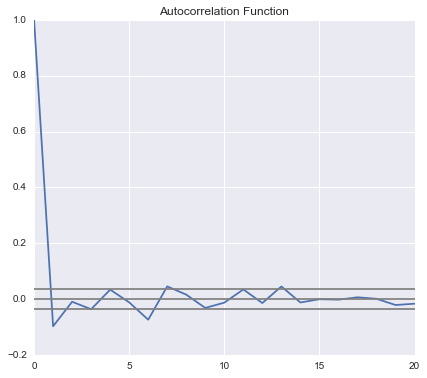

In [34]:
#Let's now plot the ACF
plt.subplot(121)
plt.plot(lag_acf)
#plt.axhline(y=0,linestyle='_',color='gray')
#plt.axhline(y=-1.96/np.sqrt(len(data3_diff)),linestyle='_',color='gray')
#plt.axhline(y=1.96/np.sqrt(len(data3_diff)),linestyle='_',color='gray')
plt.axhline(y=0,color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data3_diff)),color='gray')
plt.axhline(y=1.96/np.sqrt(len(data3_diff)),color='gray')
plt.title('Autocorrelation Function')

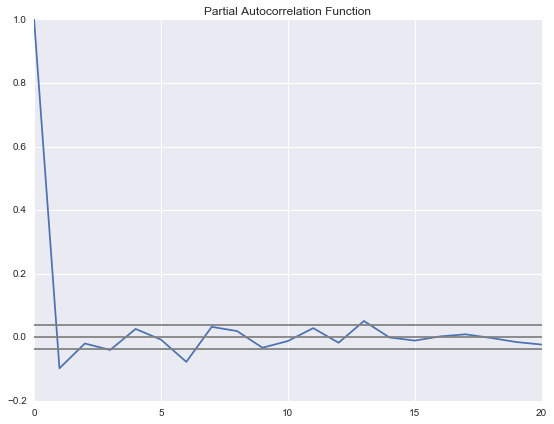

In [35]:
#Let's now plot the PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data3_diff)),color='gray')
plt.axhline(y=1.96/np.sqrt(len(data3_diff)),color='gray')
#plt.axhline(y=0,linestyle='‐‐',color='gray')
#plt.axhline(y=‐1.96/np.sqrt(len(data3_diff)),linestyle='‐‐',color='gray')
#plt.axhline(y=1.96/np.sqrt(len(data3_diff)),linestyle='‐‐',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

* By observation:
* ACF - significant lag after 1, before dropping to 0, ie. q = 1
* PACF - significant lag after 1, before dropping to 0, ie. p = 1
* the TS has been differenced, so d = 1
* Estimated ARIMA model is (1,1,1)

In [ ]:
# Next is to load the ARIMA model with the p,d,q value

# 4 - Build Arima model

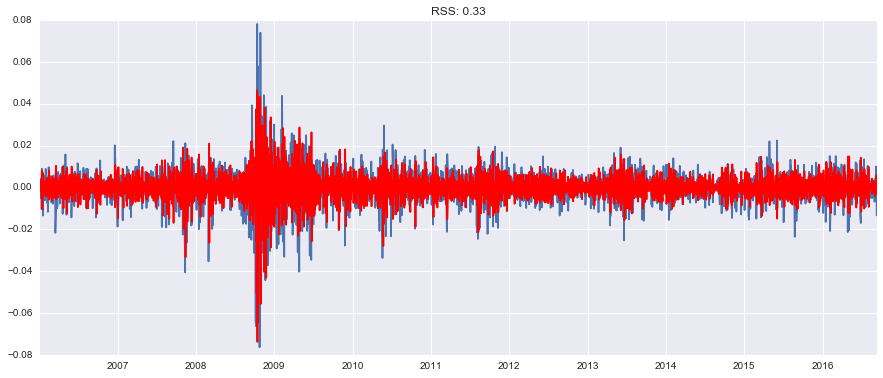

In [36]:
# Build AR (Auto-Regressive) Model first... (ARIMA order is p,d,0).. AR terms are just lags of dependent variable
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data3_diff, order=(1,1,0))
results_AR = model.fit(disp=-1)
plt.plot(data3_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.2f'% np.nansum((results_AR.fittedvalues - data3_diff)**2))

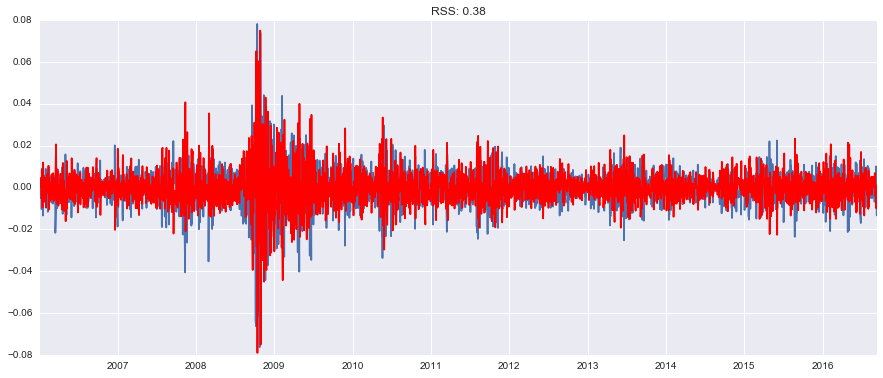

In [37]:
# Build MA Model... (ARIMA order is 0,d,q)... MA terms are lagged forecast errors; diff between moving avg and actual
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data3_diff, order=(0,1,1))
results_MA = model.fit(disp=-1)
plt.plot(data3_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.2f'% np.nansum((results_MA.fittedvalues - data3_diff)**2))

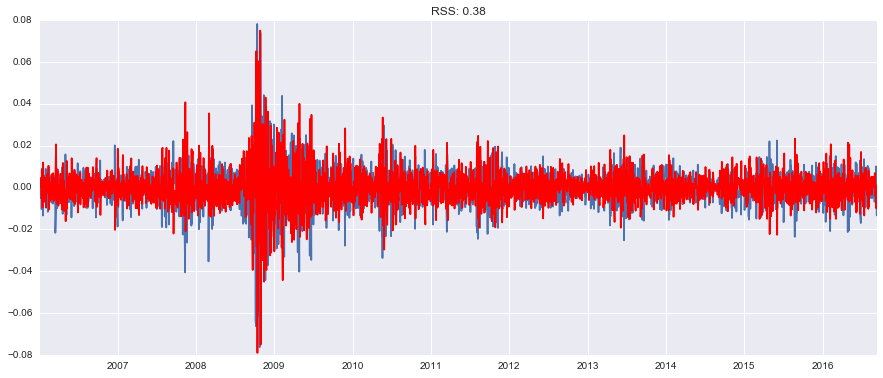

In [38]:
# Build Combined Model... (ARIMA order is p,d,q)
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data3_diff, order=(1,1,1))
results_ARMA = model.fit(disp=-1)
plt.plot(data3_diff)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RSS: %.2f'% np.nansum((results_ARMA.fittedvalues - data3_diff)**2))

In [ ]:
# Well, it looks like the RSS value of AR modle is the best (0.33) so we take this model to refit to original scale

# 5 - Make Forecast

In [39]:
# Take model back to original scale... using the best fit AR model from above
# Store predicted results as a separate series
pred_ARIMA_diff= pd.Series(results_AR.fittedvalues, copy=True)
print (pred_ARIMA_diff.head())

Date
2006-01-04   -0.000004
2006-01-05    0.000802
2006-01-06    0.003219
2006-01-09   -0.001526
2006-01-10   -0.000455
dtype: float64


In [40]:
# Need to take prediction data back to lag of 1 day.
# Do this by convert difference to base number.
# first determine the cumulative sum at index
pred_ARIMA_cumsum = pred_ARIMA_diff.cumsum()
print (pred_ARIMA_cumsum.head())

Date
2006-01-04   -0.000004
2006-01-05    0.000798
2006-01-06    0.004016
2006-01-09    0.002491
2006-01-10    0.002036
dtype: float64


In [41]:
# Next I will add them to base number. 
# For this I create a series with all values as base number and add the differences to it.
pred_ARIMA = pd.Series(data3_diff.ix[0], index=data3.index)
pred_ARIMA = pred_ARIMA.add(pred_ARIMA_cumsum,fill_value=0)
print (pred_ARIMA.head())

Date
2006-01-02    0.002656
2006-01-03    0.002656
2006-01-04    0.002652
2006-01-05    0.003454
2006-01-06    0.006672
dtype: float64


In [ ]:
# Here the first element is base number itself and from thereon the values cumulatively added. 
# Last step is to take the exponent and compare with the original series.

Date
2006-01-02    1.002660
2006-01-03    1.002660
2006-01-04    1.002656
2006-01-05    1.003460
2006-01-06    1.006695
dtype: float64
Date
2006-01-02    31.082660
2006-01-03    31.162660
2006-01-04    31.197656
2006-01-05    31.053460
2006-01-06    30.996695
dtype: float64


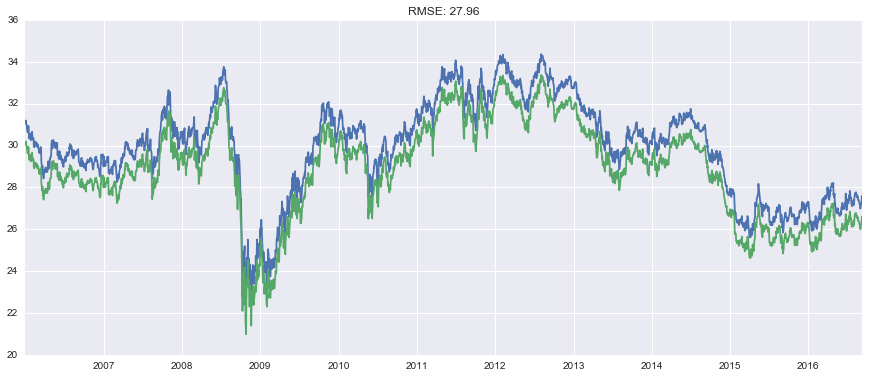

In [42]:
pred_ARIMA_revert=np.exp(pred_ARIMA)
print (pred_ARIMA_revert.head())
pred_ARR=pred_ARIMA_revert+data2.AUDTHB
print (pred_ARR.head())
plt.plot(pred_ARR)
plt.plot(data2.AUDTHB)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA‐ts)**2)/len(ts)))
plt.title('RMSE: %.2f'% np.sqrt(sum((pred_ARIMA_revert-data2.AUDTHB)**2)/len(data2.AUDTHB)))

** from here, I will plot the original data with the predicted values, with a RMSE value

In [43]:
# Another way, using state space
model = sm.tsa.statespace.SARIMAX(data2.AUDTHB, trend='n', order=(1,1,1), seasonal_order=(0,1,1,1))
results = model.fit()
print (results.summary())

                                 Statespace Model Results                                
Dep. Variable:                            AUDTHB   No. Observations:                 2790
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 1)   Log Likelihood                  70.883
Date:                           Wed, 14 Sep 2016   AIC                           -133.765
Time:                                   19:08:52   BIC                           -110.030
Sample:                               01-02-2006   HQIC                          -125.196
                                    - 09-09-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9960      0.049     20.207      0.000       0.899       1.093
ma.L1         -0.9971      0.067    -14.855

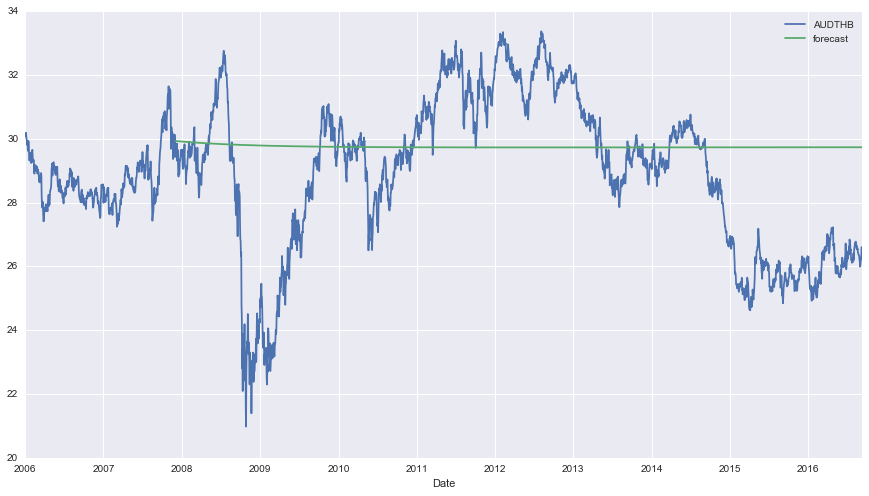

In [44]:
# make predictions
data2['forecast'] = results.predict(start = 500, end= 2790, dynamic = True)
data2[['AUDTHB','forecast']].plot(figsize=(15,8))

# Next Steps:

1. The model is poorly fitting for statespace:
* Could be because ARIMA is known to be poor method of Forex time series, as the residuals are unknown causes
* Statsmodel is not that great - next step to try Pyflux and FATS
* Also want to try ANN and SVM methods after step3

